# Drive mounting

In [ ]:
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Importing libraries

In [ ]:
!pip install --upgrade tables

     |████████████████████████████████| 4.3MB 5.5MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [ ]:
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import RobustScaler
from tensorflow import keras

# 2. Data loading

In [ ]:
train = pd.read_hdf('/content/drive/MyDrive/time-series/retail/train_online_retail.h5')
test = pd.read_hdf('/content/drive/MyDrive/time-series/retail/test_online_retail.h5')

In [ ]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520142 entries, 12 to 541909
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       520142 non-null  int32         
 1   stock_code    520142 non-null  int16         
 2   description   517903 non-null  object        
 3   quantity      520142 non-null  int32         
 4   invoice_date  520142 non-null  datetime64[ns]
 5   price_unit    520142 non-null  float16       
 6   price_total   520142 non-null  float32       
 7   customer_id   520142 non-null  int16         
 8   country       520142 non-null  object        
 9   is_canceled   520142 non-null  bool          
 10  is_test       520142 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(2)
memory usage: 25.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 547229 entries, 0 to 541893
Data columns (total 10 columns):
 

(None, None)

### Lets displaya bit and see what is inside

In [ ]:
time_info='invoice_date'

In [ ]:
def gen_time_features(orders, time_info):

  orders["date"] = orders[time_info].astype("datetime64")
  orders['year'] = orders['date'].dt.year
  orders['month'] = orders['date'].dt.month
  orders['weekday'] = orders['date'].dt.weekday
  orders['hour'] = orders['date'].dt.hour
  orders['week'] = orders['date'].dt.isocalendar().week
  return orders

In [ ]:
train= gen_time_features(train, time_info)

In [ ]:
train.sample(7)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test,date,year,month,weekday,hour,week
496416,51882,5062,LETTER HOLDER HOME SWEET HOME,1,2011-11-24 09:21:00,7.460938,7.460000,-1,United Kingdom,False,False,2011-11-24 09:21:00,2011,11,3,9,47
359263,20679,691,WOODEN PICTURE FRAME WHITE FINISH,2,2010-09-28 09:37:00,5.058594,10.120000,-1,United Kingdom,False,False,2010-09-28 09:37:00,2010,9,1,9,39
444024,49716,194,3 DRAWER ANTIQUE WHITE WOOD CABINET,2,2011-11-06 14:35:00,8.953125,17.900000,1094,United Kingdom,False,False,2011-11-06 14:35:00,2011,11,6,14,44
434325,24599,476,RECYCLED PENCIL WITH RABBIT ERASER,14,2010-11-04 14:49:00,0.429932,6.020000,-1,United Kingdom,False,False,2010-11-04 14:49:00,2010,11,3,14,44
492564,51743,3289,ZINC FOLKART SLEIGH BELLS,72,2011-11-23 10:38:00,1.490234,107.279999,5086,United Kingdom,False,False,2011-11-23 10:38:00,2011,11,2,10,47
365795,21091,928,CERAMIC CAKE DESIGN SPOTTED MUG,1,2010-09-30 19:57:00,1.490234,1.490000,3634,United Kingdom,False,False,2010-09-30 19:57:00,2010,9,3,19,39
496823,51885,4342,FRENCH TOILET SIGN BLUE METAL,1,2011-11-24 09:26:00,2.460938,2.460000,-1,United Kingdom,False,False,2011-11-24 09:26:00,2011,11,3,9,47


In [ ]:
train.groupby('customer_id').mean()

,invoice,stock_code,quantity,price_unit,price_total,is_canceled,is_test,year,month,weekday,hour,week
customer_id,,,,,,,,,,,,
-1,28408.608052,1990.442781,6.757912,9.546875,15.439903,0.002728,0.0,2010.443434,7.313083,1.905794,13.580860,29.755380
0,33053.142857,2210.809524,13.380952,42.062500,59.615238,0.380952,0.0,2010.952381,3.047619,3.047619,14.095238,11.952381
1,26465.803279,1660.275956,15.183060,4.066406,35.301529,0.081967,0.0,2010.327869,7.822404,2.412568,12.579235,32.133880
2,8423.950000,605.225000,9.200000,3.611328,15.327000,0.000000,0.0,2009.425000,10.725000,2.275000,9.425000,43.900000
3,27627.415663,2302.016064,159.588353,4.144531,541.268982,0.006024,0.0,2010.417671,7.542169,1.953815,12.985944,30.630522
...,...,...,...,...,...,...,...,...,...,...,...,...
5930,53196.000000,3195.303030,19.454545,0.585449,9.473333,0.000000,0.0,2011.000000,12.000000,1.000000,11.000000,49.000000
5935,53292.000000,2315.041667,10.000000,2.451172,7.026250,0.000000,0.0,2011.000000,12.000000,1.000000,17.000000,49.000000
5936,53342.500000,5182.000000,385.000000,8.328125,2024.250000,0.000000,0.0,2011.000000,12.000000,2.000000,12.000000,49.000000


In [ ]:
train.groupby('customer_id').sum()

,invoice,stock_code,quantity,price_unit,price_total,is_canceled,is_test,year,month,weekday,hour,week
customer_id,,,,,,,,,,,,
-1,3.176026e+09,222527522.0,755521.0,inf,1.726150e+06,305,0,224763555,817588,213064,1518313,3326592
0,6.941160e+05,46427.0,281.0,883.500000,1.251920e+03,8,0,42230,64,64,296,251
1,9.686484e+06,607661.0,5557.0,1488.000000,1.292036e+04,30,0,735780,2863,883,4604,11761
2,3.369580e+05,24209.0,368.0,144.500000,6.130800e+02,0,0,80377,429,91,377,1756
3,1.375845e+07,1146404.0,79475.0,2064.000000,2.695519e+05,3,0,1001188,3756,973,6467,15254
...,...,...,...,...,...,...,...,...,...,...,...,...
5930,1.755468e+06,105445.0,642.0,19.328125,3.126200e+02,0,0,66363,396,33,363,1617
5935,1.279008e+06,55561.0,240.0,58.812500,1.686300e+02,0,0,48264,288,24,408,1176
5936,1.066850e+05,10364.0,770.0,16.656250,4.048500e+03,0,0,4022,24,4,24,98


In [ ]:
train.groupby('year').mean()

,invoice,stock_code,quantity,price_unit,price_total,customer_id,is_canceled,is_test,month,weekday,hour,week
year,,,,,,,,,,,,
2009,1089.402085,828.524690,10.186714,4.363281,19.205385,309.596100,0.022833,0.0,12.000000,2.191779,13.467924,50.133789
2010,16982.128064,1721.492197,12.431299,5.390625,21.288288,1246.374914,0.020498,0.0,7.326510,2.558513,12.934823,29.636717
2011,42317.291415,2604.843940,12.126052,4.789062,22.531723,1886.198696,0.017418,0.0,7.189698,2.432705,12.957672,29.220905


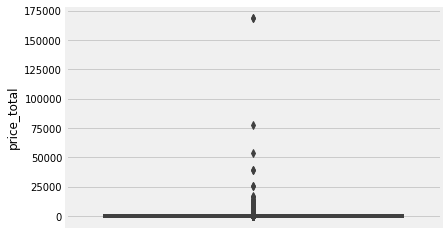

In [ ]:
sns.boxplot(y=train['price_total']);

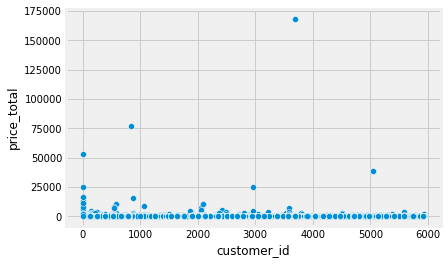

In [ ]:
sns.scatterplot(x = "customer_id", y = "price_total", data = train);

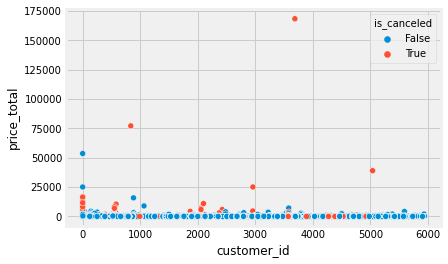

In [ ]:
sns.scatterplot(x = "customer_id", y = "price_total", data = train, hue='is_canceled');

It looks like above 25000 thous there are outliers

https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
https://androidkt.com/detect-and-remove-outliers-from-pandas-dataframe/

In [ ]:
#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
#------------------------------------------------------------------------------
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out



In [ ]:
def remove_outlier(df_in, col_name, low):

    print('percetaile removed below/above --->{}/ {}'.format(low*100, 100-low*100))
    q1 = df_in[col_name].quantile(low)
    q3 = df_in[col_name].quantile(1-low)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    sns.boxplot(y=df_out[col_name]);

    return df_out

percetaile removed below/above --->20.0/ 80.0


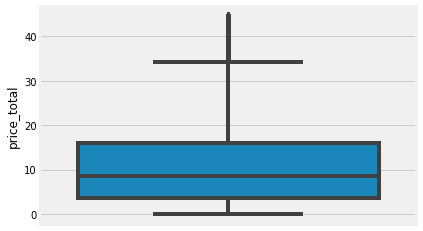

In [ ]:
low= 0.2
col_name='price_total'
train= remove_outlier(train, col_name, low)

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


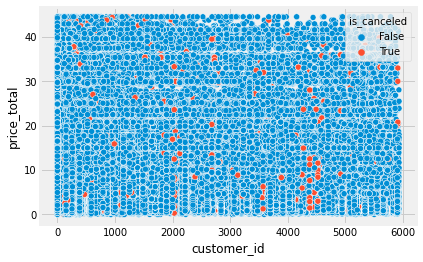

In [ ]:
sns.scatterplot(x = "customer_id", y = "price_total", data = train, hue='is_canceled');

In [ ]:
# orders_top = orders[orders['price_total'] >= 25000]
# orders_r = orders[orders['price_total'] < 25000]
# orders_rr = orders_r[orders_r['customer_id'].isin(regulars)]
# orders_rn = orders_r[~orders_r['customer_id'].isin(regulars)]

# 2a. Data loading

In [ ]:
def read_and_parse_data(file_name):
    df = pd.read_hdf('/content/drive/MyDrive/time-series/retail/{}'.format(file_name)).reset_index(drop=True)
    df.index = pd.to_datetime( df['invoice_date'] )
    
    return df


train = read_and_parse_data('train_online_retail.h5')
test = read_and_parse_data('test_online_retail.h5')

# 3. Initial looking at the data from time perspective

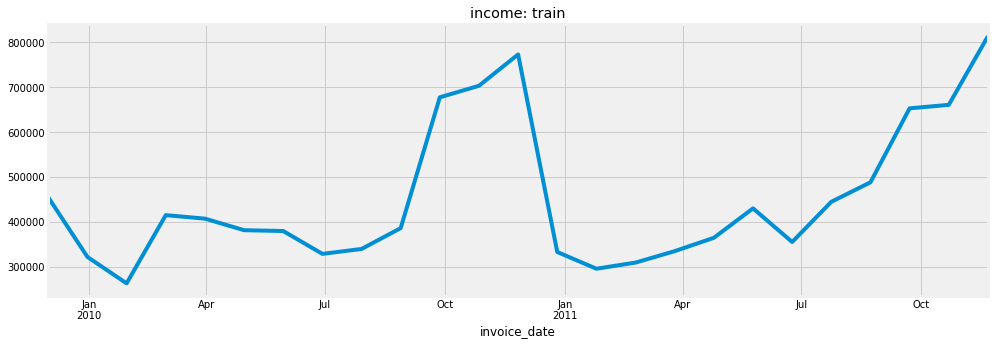

In [ ]:
train.resample('30d').sum()['price_total'].plot(title='income: train', figsize=(15, 5));

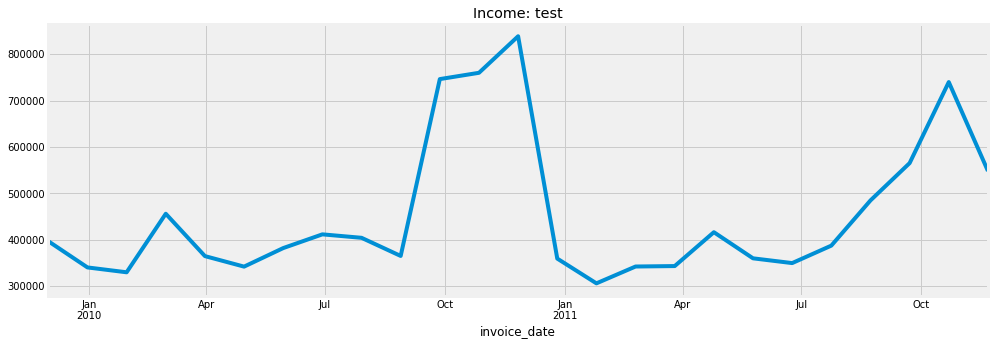

In [ ]:
test.resample('30d').sum()['price_total'].plot(title='Income: test', figsize=(15, 5));

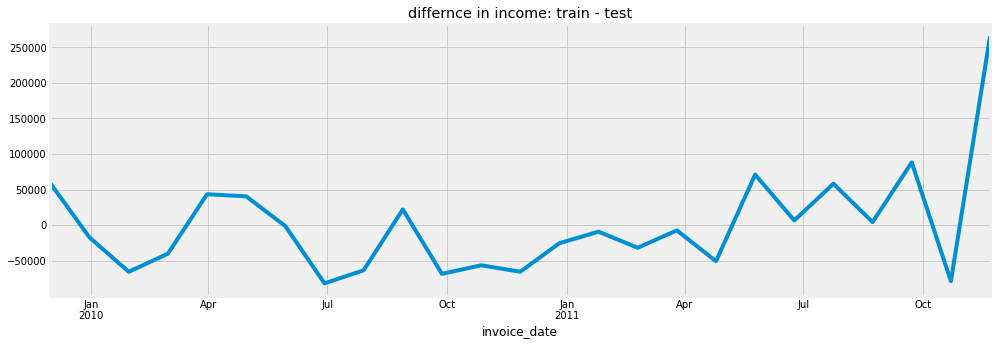

In [ ]:
diff = train.resample('30d').sum()['price_total'] - test.resample('30d').sum()['price_total']
diff.plot(title='differnce in income: train - test', figsize=(15, 5));

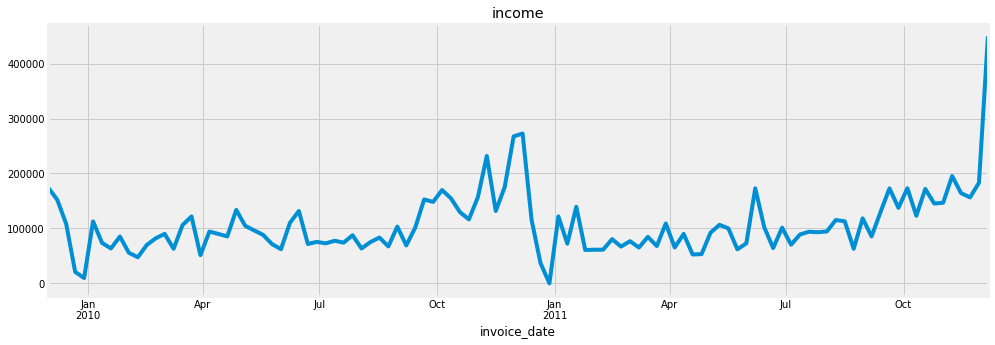

In [ ]:
train.resample('7d').sum()['price_total'].plot(title='income', figsize=(15, 5));

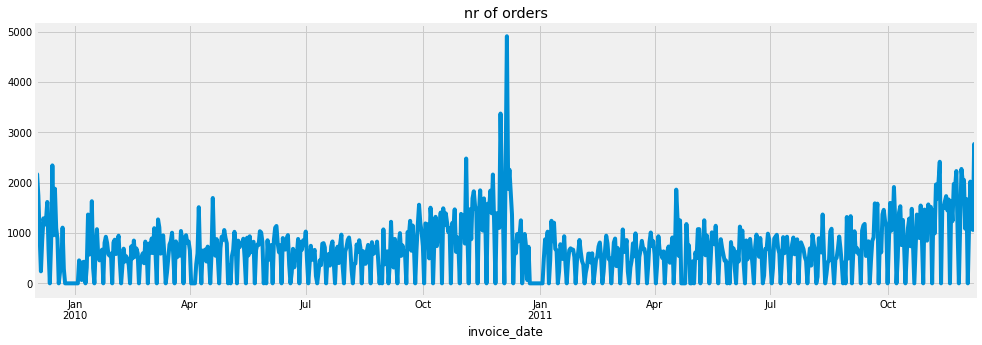

In [ ]:
train.resample('1d').agg(np.size)['price_total'].plot(title='nr of orders', figsize=(15, 5));

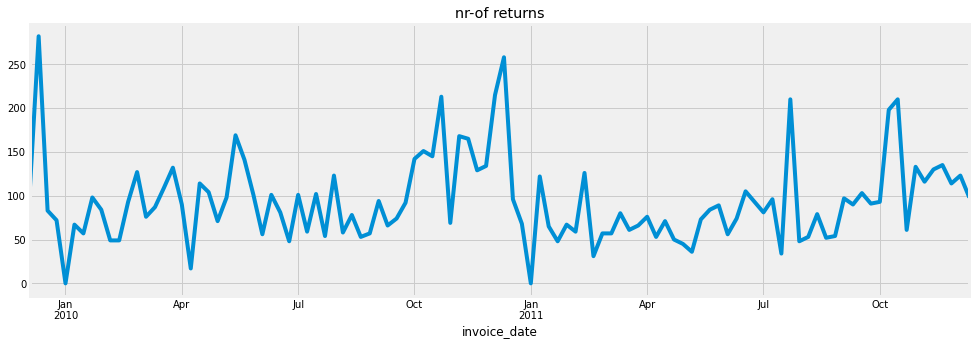

In [ ]:
train[ True == train.is_canceled ].resample('1w').agg(np.size)['price_total'].plot(title='nr-of returns', figsize=(15, 5));

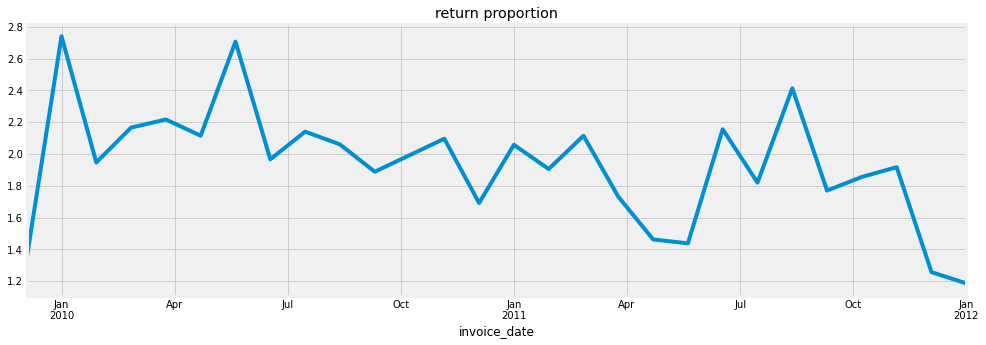

In [ ]:
ratio = train[ True == train.is_canceled ].resample('4w').agg(np.size)['price_total'] / train.resample('4w').agg(np.size)['price_total'] * 100
ratio.plot(title='return proportion', figsize=(15, 5));

# 4. Preprocessing

In [ ]:
train.sample(15)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test
invoice_date,,,,,,,,,,,
2011-09-21 15:22:00,45643,1161,DOTCOM POSTAGE,1,2011-09-21 15:22:00,148.500000,148.550003,-1,United Kingdom,False,False
2011-12-01 11:53:00,52689,856,MOTORING TISSUE BOX,2,2011-12-01 11:53:00,0.389893,0.780000,3229,United Kingdom,False,False
2011-10-20 12:03:00,48156,4861,SET OF 3 HANGING OWLS OLLIE BEAK,192,2011-10-20 12:03:00,1.040039,199.679993,208,Netherlands,False,False
2010-09-26 14:43:00,20541,4277,CHRISTMAS RETROSPOT ANGEL WOOD,5,2010-09-26 14:43:00,0.850098,4.250000,1529,United Kingdom,False,False
2011-11-02 14:57:00,49357,4919,DRAWER KNOB CRACKLE GLAZE PINK,6,2011-11-02 14:57:00,1.650391,9.900000,4548,Germany,False,False
2011-07-06 13:14:00,40813,4880,ROUND STORAGE TIN VINTAGE LEAF,6,2011-07-06 13:14:00,1.950195,11.700000,4921,France,False,False
2010-11-29 13:59:00,27514,4616,JAM MAKING SET WITH JARS,6,2010-11-29 13:59:00,4.250000,25.500000,1417,United Kingdom,False,False
2010-06-23 14:34:00,14254,2802,PINK HEARTS PAPER GARLAND,12,2010-06-23 14:34:00,1.650391,19.799999,2997,United Kingdom,False,False
2011-04-03 15:07:00,34731,1119,ENVELOPE 50 ROMANTIC IMAGES,1,2011-04-03 15:07:00,0.850098,0.850000,4499,United Kingdom,False,False


takie cos nie dalo zupelnie nic

In [ ]:
train['ratio'] = train[ True == train.is_canceled ].resample('4w').agg(np.size)['price_total'] / train.resample('4w').agg(np.size)['price_total'] * 100

return propotion prediction lets build some model topredict that

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 520142 entries, 2009-12-01 09:06:00 to 2011-12-09 12:50:00
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       520142 non-null  int32         
 1   stock_code    520142 non-null  int16         
 2   description   517903 non-null  object        
 3   quantity      520142 non-null  int32         
 4   invoice_date  520142 non-null  datetime64[ns]
 5   price_unit    520142 non-null  float16       
 6   price_total   520142 non-null  float32       
 7   customer_id   520142 non-null  int16         
 8   country       520142 non-null  object        
 9   is_canceled   520142 non-null  bool          
 10  is_test       520142 non-null  bool          
 11  ratio         0 non-null       float32       
dtypes: bool(2), datetime64[ns](1), float16(1), float32(2), int16(2), int32(2), object(2)
memory usage: 27.8+ MB


In [ ]:
def dist(df):
    print('detailed')
    print(df.index[:10])
    print( df.is_canceled.value_counts(normalize=True).values * 100)
    
    df_agg = df.groupby('invoice').sum()
    df_agg['is_canceled'] = (df_agg['is_canceled'] > 0).astype(np.int)

    print('orders')
    print(df_agg['is_canceled'].value_counts(normalize=True).values * 100)

In [ ]:
dist(train)

detailed
DatetimeIndex(['2009-12-01 09:06:00', '2009-12-01 09:06:00',
               '2009-12-01 09:06:00', '2009-12-01 09:06:00',
               '2009-12-01 09:06:00', '2009-12-01 09:06:00',
               '2009-12-01 09:06:00', '2009-12-01 09:06:00',
               '2009-12-01 09:06:00', '2009-12-01 09:06:00'],
              dtype='datetime64[ns]', name='invoice_date', freq=None)
[98.0837925  1.9162075]
orders
[84.53792795 15.46207205]


In [ ]:
train_agg = train.groupby('invoice')[ ['price_total',  'is_canceled'] ].sum()
train_agg['is_canceled'] = train_agg['is_canceled'] > 0
train_agg['total_return'] = train_agg['price_total'] * train_agg['is_canceled']

In [ ]:
train_agg.sample(7)

,price_total,is_canceled,total_return
invoice,,,
39441,109.200005,False,0.000000
9820,239.649994,False,0.000000
18002,434.190002,False,0.000000
9042,227.279999,True,227.279999
45180,659.440002,False,0.000000
50593,161.639999,False,0.000000
34326,579.830017,False,0.000000


In [ ]:
new= pd.merge(train, train_agg, left_on='invoice', right_on='invoice')

In [ ]:
new.sample(7).T

,459887,348806,508022,22082,30514,339973,397293
invoice,48631,37331,52634,2078,2984,36281,42788
stock_code,196,2261,2120,650,584,3429,17
description,PACK OF 72 RETROSPOT CAKE CASES,CHERRY BLOSSOM DECORATIVE FLASK,3 ROSE MORRIS BOXED CANDLES,S/16 VINTAGE SKY BLUE CUTLERY,S/4 FESTIVE RED DINNER CANDLES,JUMBO BAG PINK POLKADOT,CHRISTMAS CRAFT WHITE FAIRY
quantity,12,1,24,1,1,10,6
invoice_date,2011-10-26 12:14:00,2011-05-13 15:53:00,2011-12-01 08:52:00,2009-12-21 15:13:00,2010-01-17 12:12:00,2011-04-28 13:35:00,2011-08-05 15:02:00
price_unit,0.549805,8.28906,1.25,12.75,1.25,2.08008,1.4502
price_total_x,6.6,8.29,30,12.75,1.25,20.8,8.7
customer_id,3301,-1,27,-1,1182,1075,5006
country,United Kingdom,United Kingdom,EIRE,United Kingdom,United Kingdom,United Kingdom,Germany
is_canceled_x,False,False,False,False,False,False,False


In [ ]:
new[new["invoice"]==2178]

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total_x,customer_id,country,is_canceled_x,is_test,ratio,price_total_y,is_canceled_y,total_return
22924,2178,271,GLITTER STAR GARLAND WITH BELLS,1,2009-12-22 13:08:00,3.750000,3.75,160,United Kingdom,True,False,NaN,68.139999,True,68.139999
22925,2178,745,PAINTED METAL TREE WITH HOLLY BELLS,3,2009-12-22 13:08:00,1.450195,4.35,160,United Kingdom,True,False,NaN,68.139999,True,68.139999
22926,2178,785,HEART GARLAND RUSTIC PADDED,1,2009-12-22 13:08:00,2.949219,2.95,160,United Kingdom,True,False,NaN,68.139999,True,68.139999
22927,2178,1348,CHRISTMAS TREE PAINTED ZINC,1,2009-12-22 13:08:00,0.649902,0.65,160,United Kingdom,True,False,NaN,68.139999,True,68.139999
22928,2178,725,WHITE CHRISTMAS STAR DECORATION,1,2009-12-22 13:08:00,0.419922,0.42,160,United Kingdom,True,False,NaN,68.139999,True,68.139999
22929,2178,280,HEART DECORATION PAINTED ZINC,1,2009-12-22 13:08:00,0.649902,0.65,160,United Kingdom,True,False,NaN,68.139999,True,68.139999
22930,2178,359,ANGEL DECORATION 3 BUTTONS,1,2009-12-22 13:08:00,0.419922,0.42,160,United Kingdom,True,False,NaN,68.139999,True,68.139999
22931,2178,1348,CHRISTMAS TREE PAINTED ZINC,2,2009-12-22 13:08:00,0.649902,1.30,160,United Kingdom,True,False,NaN,68.139999,True,68.139999
22932,2178,351,CAKE PLATE LOVEBIRD WHITE,1,2009-12-22 13:08:00,4.949219,4.95,160,United Kingdom,True,False,NaN,68.139999,True,68.139999
22933,2178,1905,BEADED PEARL HEART WHITE ON STICK,1,2009-12-22 13:08:00,1.250000,1.25,160,United Kingdom,True,False,NaN,68.139999,True,68.139999


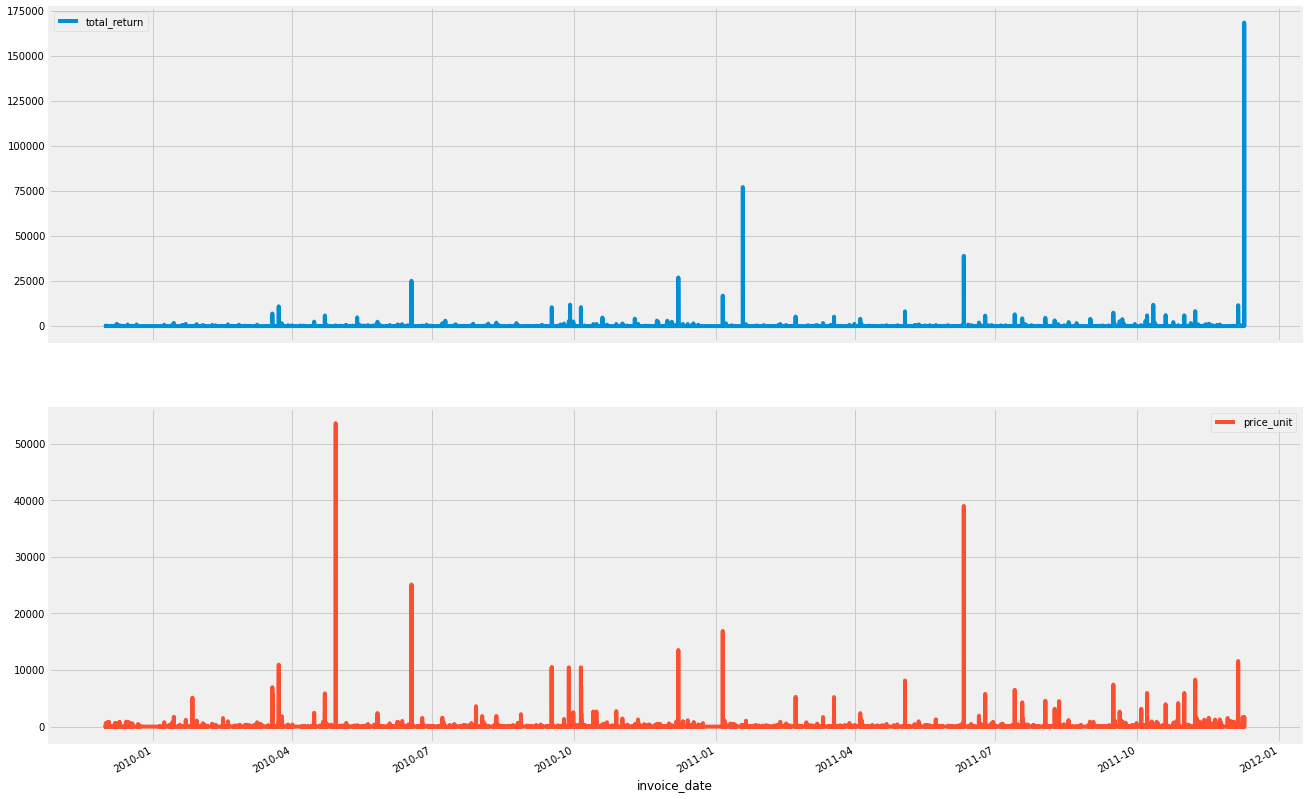

In [ ]:
new[['invoice_date','total_return', 'price_unit']].plot(x='invoice_date', subplots=True, figsize=(20,15))
plt.show()

Counting (ratio _stock_code_rat_, number _stock_code_canc_) canceled articles

In [ ]:
stock_code_num = dict(train['stock_code'].value_counts())
stock_code_canc =  dict(train[train['is_canceled'] == True]['stock_code'].value_counts())

stock_code_rat = {}

for key in stock_code_num:
    if key not in stock_code_canc:
        stock_code_canc[key] = 0
        stock_code_rat[key] = 0
    else:
        stock_code_rat[key] = stock_code_canc[key]/stock_code_num[key]
        
mean_canc = np.mean(list(stock_code_canc.values()))
mean_rat = np.mean(list(stock_code_rat.values()))

stock_code_canc = defaultdict(lambda: mean_canc, stock_code_canc)
stock_code_rat = defaultdict(lambda: mean_rat, stock_code_rat)

In [ ]:
mean_canc, mean_rat 

(1.9752279032897344, 0.021590560689142703)

In [ ]:
stock_code_rat

defaultdict(<function __main__.<lambda>>,
            {91: 0.02589779005524862,
             3907: 0.07979936160510716,
             141: 0.024472168905950095,
             196: 0.00857843137254902,
             145: 0.025308241401687217,
             4: 0.06412103746397695,
             15: 0.0072254335260115606,
             749: 0.007976794778825236,
             388: 0.035856573705179286,
             3348: 0.0128,
             557: 0.01700404858299595,
             274: 0.01675041876046901,
             3429: 0.015437392795883362,
             3434: 0.008802816901408451,
             472: 0.0026785714285714286,
             596: 0.005390835579514825,
             4050: 0.006289308176100629,
             134: 0.005420054200542005,
             174: 0.010009099181073703,
             72: 0.01916058394160584,
             3349: 0.006386861313868613,
             71: 0.10497237569060773,
             86: 0.10823311748381129,
             14: 0.010175763182238668,
             420: 0.0

In [ ]:
train['stock_code_rat'] = train['stock_code'].map(stock_code_rat)
train['stock_code_canc'] = train['stock_code'].map(stock_code_canc)

In [ ]:
train.sample(7).T

invoice_date,2010-07-29 15:04:00,2010-12-14 13:19:00,2010-11-15 16:22:00,2009-12-07 11:46:00,2011-12-05 14:40:00,2010-10-05 18:39:00,2010-03-28 16:04:00
invoice,16743,29137,25899,708,53091,21542,8003
stock_code,317,4457,324,1588,146,1414,106
description,GRAND CHOCOLATECANDLE,HOT WATER BOTTLE BABUSHKA,NO SINGING METAL SIGN,HOME GARLAND PAINTED ZINC,LUNCH BAG CARS BLUE,S/4 IVORY MINI ROSE CANDLE IN BOWL,BINGO SET
quantity,9,36,3,12,2,48,2
invoice_date,2010-07-29 15:04:00,2010-12-14 13:19:00,2010-11-15 16:22:00,2009-12-07 11:46:00,2011-12-05 14:40:00,2010-10-05 18:39:00,2010-03-28 16:04:00
price_unit,1.4502,4.25,2.09961,1.65039,1.65039,0.419922,3.75
price_total,13.05,153,6.3,19.8,3.3,20.16,7.5
customer_id,777,346,87,486,197,226,1432
country,United Kingdom,United Kingdom,United Kingdom,Greece,United Kingdom,United Kingdom,United Kingdom
is_canceled,False,False,False,False,False,False,False


# 5. Features generation per an invoice

In [ ]:
orders = train.groupby('invoice').agg(
    num_canceled=('is_canceled', sum), item_num=('price_total', 'count'),
    price_total=('price_total', sum), m_expensive_item_total=('price_total', max),
    item_median_total=('price_total', np.median), l_expensive_item_total=('price_total', min),
    sum_quant=('quantity', sum), great_quant=('quantity', max), least_quent=('quantity', min),
    date=('invoice_date', 'first'), country=('country', 'first'),
    customer_id=('customer_id', 'first'),
    mean_scrat=('stock_code_rat', np.mean), min_scrat=('stock_code_rat', min),
    max_scrat=('stock_code_rat', max),
    mean_sccanc=('stock_code_canc', np.mean), min_sccanc=('stock_code_canc', min),
    max_sccanc=('stock_code_canc', max))

# Time features

orders["date"] = orders['date'].astype("datetime64")
orders['year'] = orders['date'].dt.year
orders['month'] = orders['date'].dt.month
orders['weekday'] = orders['date'].dt.weekday
orders['hour'] = orders['date'].dt.hour


orders['is_canceled'] = orders['num_canceled'] > 0
orders['total_return'] = orders['price_total'] * orders['is_canceled']

orders['country_val'] = pd.factorize(orders['country'])[0]
orders['week'] = orders['date'].dt.isocalendar().week

In [ ]:
orders.sample(10).T

invoice,19479,19495,48858,27715,17096,28678,22973,18203,7914,19046
num_canceled,0,0,0,1,0,0,0,0,0,0
item_num,19,12,3,1,33,26,13,1,31,77
price_total,229.17,385.9,70.68,3.75,340.59,1313.4,256.83,15.6,84.37,355.71
m_expensive_item_total,50.98,87,45,3.75,64.17,153,62.4,15.6,9.9,20.65
item_median_total,6.72,18.15,18.72,3.75,5.91,47.7,15.8,15.6,1.95,3.3
l_expensive_item_total,0.81,10.5,6.96,3.75,0.85,17.4,9.95,15.6,0.55,0.55
sum_quant,25,252,108,3,40,300,203,8,37,224
great_quant,4,50,48,3,4,18,96,8,4,25
least_quent,1,2,24,3,1,6,1,8,1,1
date,2010-09-13 12:26:00,2010-09-13 13:09:00,2011-10-28 09:29:00,2010-11-30 16:40:00,2010-08-04 16:11:00,2010-12-09 12:49:00,2010-10-19 16:56:00,2010-08-22 14:56:00,2010-03-26 14:01:00,2010-09-06 12:55:00


## Second time looking at the data tabular and charts

In [ ]:
agg_funcs = [np.mean, np.median, np.std, np.size]
pd.pivot_table(orders, index=["month","year"], values=["total_return"], aggfunc=agg_funcs)

mean       median          std         size
           total_return total_return total_return total_return
month year                                                    
1     2010    14.475306          0.0   104.148738        801.0
      2011   170.007050          0.0  3042.678268        703.0
2     2010     6.871393          0.0    50.383111        991.0
      2011    16.771799          0.0   210.115179        678.0
3     2010    40.378967          0.0   523.967188       1191.0
      2011    17.466459          0.0   189.084613       1017.0
4     2010    17.555069          0.0   212.074775        945.0
      2011    11.039572          0.0   143.488364        888.0
5     2010    17.766338          0.0   176.002425       1226.0
      2011    22.824549          0.0   333.246634       1053.0
6     2010    43.514210          0.0   776.990527       1107.0
      2011    61.364063          0.0  1255.153975       1002.0
7     2010    15.608255          0.0   127.406761        986.0
      2011    27.081673          0.0   302.100326        933.0
8     2010    11.921511          0.0    99.928020        953.0
      2011    30.324598          0.0   282.825605        859.0
9     2010    34.983311          0.0   481.009191       1193.0
      2011    22.054871          0.0   268.779700       1189.0
10    2010    21.984491          0.0   311.559691       1505.0
      2011    39.436432          0.0   454.447252       1326.0
11    2010    14.891657          0.0   159.637411       1865.0
      2011    13.799732          0.0   213.063673       1718.0
12    2009     8.697248          0.0    60.194832       1177.0
      2010    70.787994          0.0  1017.349866       1008.0
      2011   366.767181          0.0  7550.731025        500.0

## Lets put some keras into acton and time series based on orders where there are plenty of features

## changing domain to time

In [ ]:
def change_persepctive_to_time(df, column):
    df = orders.reset_index(drop=True)
    df.index = pd.to_datetime( df[column] )
    return df


In [ ]:
column= 'date' #column where there is information about the time
orders = change_persepctive_to_time(orders, column)

In [ ]:
orders.sample(4)

,num_canceled,item_num,price_total,m_expensive_item_total,item_median_total,l_expensive_item_total,sum_quant,great_quant,least_quent,date,country,customer_id,mean_scrat,min_scrat,max_scrat,mean_sccanc,min_sccanc,max_sccanc,year,month,weekday,hour,is_canceled,total_return,country_val,week
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-02 16:18:00,0,1,0.000000,0.000000,0.00,0.00,7,7,7,2010-03-02 16:18:00,United Kingdom,-1,0.000000,0.000000,0.000000,0.000000,0,0,2010,3,1,16,False,0.000000,0,9
2011-02-04 11:22:00,2,2,46.200001,23.100000,23.10,23.10,28,14,14,2011-02-04 11:22:00,United Kingdom,-1,0.018667,0.014925,0.022409,5.500000,3,8,2011,2,4,11,True,46.200001,0,5
2010-02-21 14:57:00,0,20,160.190002,23.799999,8.40,1.25,74,8,1,2010-02-21 14:57:00,United Kingdom,567,0.014686,0.000000,0.089888,10.050000,0,75,2010,2,6,14,False,0.000000,0,7
2010-12-16 17:53:00,0,15,357.940002,75.599998,20.16,4.56,386,48,4,2010-12-16 17:53:00,United Kingdom,759,0.019293,0.000000,0.068111,4.333333,0,44,2010,12,3,17,False,0.000000,0,50


## total return will be our target  befo there is need for some regularisation


```
orders['total_return']
```




Based on subplots there are some information to get from data

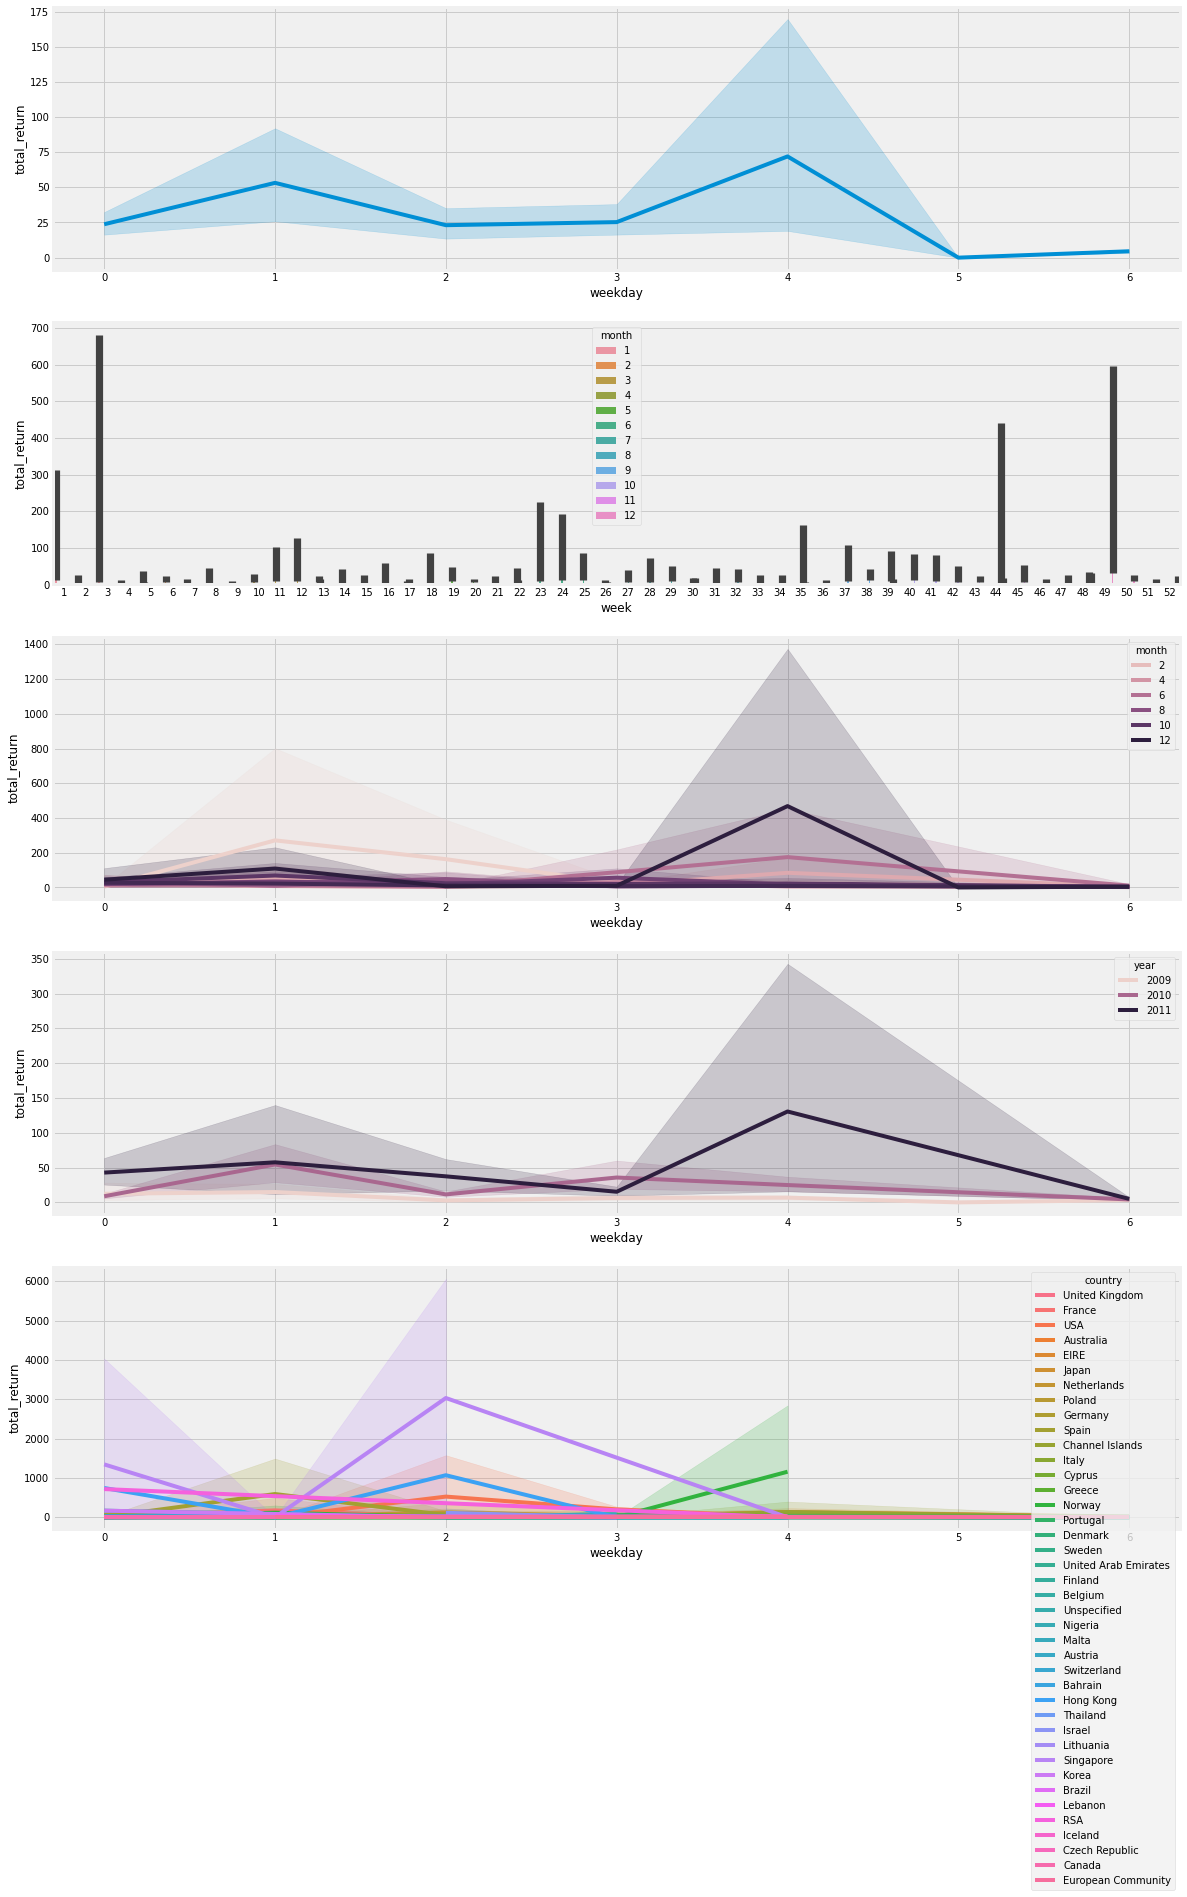

In [ ]:
fig,(ax1, ax2, ax3, ax4, ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18, 28)

sns.lineplot(data=orders, x='weekday', y='total_return', ax=ax1)
sns.barplot(data=orders, x='week', y='total_return', hue='month', ax=ax2)
sns.lineplot(data=orders, x='weekday', y='total_return', hue='month', ax=ax3)
sns.lineplot(data=orders, x='weekday', y='total_return', hue='year', ax=ax4)
sns.lineplot(data=orders, x='weekday', y='total_return', hue='country', ax=ax5);

# 6. Preparing model

In [ ]:
orders.fillna(value='', inplace=True)

In [ ]:
def split_train_test( df, ratio):
  train_size = int(len(df) * ratio)
  test_size = len(df) - train_size
  train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
  print(len(train), len(test))
  return train, test


In [ ]:
ratio= 0.9
train, test= split_train_test( orders, ratio)

24132 2682


In [ ]:
def get_feats(df):
    black_list = ['date', 'country', ' 	is_canceled', 'total_return', 'num_canceled']
    feats = df.select_dtypes(include=[np.number]).columns
    
    feats = [feat for feat in feats if feat not in black_list]
    return feats

In [ ]:
feats= get_feats(orders)
feats

['item_num',
 'price_total',
 'm_expensive_item_total',
 'item_median_total',
 'l_expensive_item_total',
 'sum_quant',
 'great_quant',
 'least_quent',
 'customer_id',
 'mean_scrat',
 'min_scrat',
 'max_scrat',
 'mean_sccanc',
 'min_sccanc',
 'max_sccanc',
 'year',
 'month',
 'weekday',
 'hour',
 'country_val',
 'week']

In [ ]:

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[feats].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['total_return']])

train.loc[:, feats] = f_transformer.transform(train[feats].to_numpy())
train['total_return'] = cnt_transformer.transform(train[['total_return']])

test.loc[:, feats] = f_transformer.transform(test[feats].to_numpy())
test['total_return'] = cnt_transformer.transform(test[['total_return']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [ ]:
len(X), len(y)

(26814, 26814)

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[feats], train.total_return, time_steps)
X_test, y_test = create_dataset(test[feats], test.total_return, time_steps)

print(X_train.shape, y_train.shape)

(24122, 10, 21) (24122,)


In [ ]:
# X_train = np.asarray(X_train).astype(np.float32)
# X_test = np.asarray(X_test).astype(np.float32)

In [ ]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f9bcb028c90>>

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
679/679 [==============================] - 18s 20ms/step - loss: 509000.0312 - val_loss: 142771.8594
Epoch 2/30
679/679 [==============================] - 13s 19ms/step - loss: 508639.9375 - val_loss: 142824.0781
Epoch 3/30
679/679 [==============================] - 13s 19ms/step - loss: 508370.5625 - val_loss: 142682.4375
Epoch 4/30
679/679 [==============================] - 13s 19ms/step - loss: 508267.1562 - val_loss: 142916.2500
Epoch 5/30
679/679 [==============================] - 13s 19ms/step - loss: 508201.6875 - val_loss: 142814.5625
Epoch 6/30
679/679 [==============================] - 13s 19ms/step - loss: 507701.5625 - val_loss: 142907.2344
Epoch 7/30
679/679 [==============================] - 13s 19ms/step - loss: 507213.7812 - val_loss: 142900.0938
Epoch 8/30
679/679 [==============================] - 13s 19ms/step - loss: 506887.3125 - val_loss: 142834.2969
Epoch 9/30
679/679 [==============================] - 13s 19ms/step - loss: 506482.6562 - val_loss: 1428

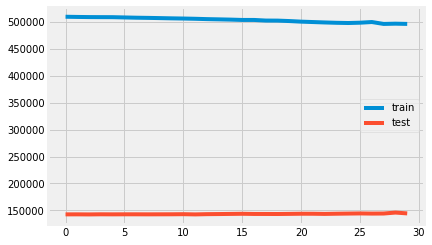

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

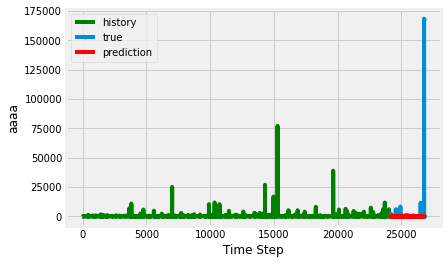

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('aaaa')
plt.xlabel('Time Step')
plt.legend()

plt.show();

### with this partiicular time step it does not look good actually there is nothing or very little what model learned, there is need to resample per an hour and summ 

https://towardsdatascience.com/pandas-resample-tricks-you-should-know-for-manipulating-time-series-data-7e9643a7e7f3

# 7. Next iteration to get some reasonable reaults

In [ ]:
orders_daily= orders.resample('1d').sum()

In [ ]:
orders.head(5)

,num_canceled,item_num,price_total,m_expensive_item_total,item_median_total,l_expensive_item_total,sum_quant,great_quant,least_quent,date,country,customer_id,mean_scrat,min_scrat,max_scrat,mean_sccanc,min_sccanc,max_sccanc,year,month,weekday,hour,is_canceled,total_return,country_val,week
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-12-01 09:06:00,0,19,630.330017,102.0,19.799999,10.000000,193,24,2,2009-12-01 09:06:00,United Kingdom,1,-0.023450,0.0,0.784330,-0.161791,0,19,2009,12,1,9,False,0.0,0,49
2009-12-01 09:08:00,0,23,310.750000,17.9,13.500000,7.800000,145,12,1,2009-12-01 09:08:00,United Kingdom,2,0.134652,0.0,0.446770,-0.290883,0,23,2009,12,1,9,False,0.0,0,49
2009-12-01 09:24:00,0,17,2286.239990,384.0,114.000000,27.440001,826,60,28,2009-12-01 09:24:00,United Kingdom,3,-0.375417,0.0,-0.284213,-0.557201,0,5,2009,12,1,9,False,0.0,0,49
2009-12-01 09:28:00,0,19,426.299988,54.0,17.850000,7.800000,219,25,2,2009-12-01 09:28:00,France,4,0.471498,0.0,0.550989,1.205486,0,117,2009,12,1,9,False,0.0,1,49
2009-12-01 09:46:00,0,23,382.369995,60.0,15.000000,5.040000,275,48,2,2009-12-01 09:46:00,United Kingdom,6,-0.519002,0.0,-0.320713,-0.144380,0,75,2009,12,1,9,False,0.0,0,49


In [ ]:
orders_daily.head(5)

,num_canceled,item_num,price_total,m_expensive_item_total,item_median_total,l_expensive_item_total,sum_quant,great_quant,least_quent,customer_id,mean_scrat,min_scrat,max_scrat,mean_sccanc,min_sccanc,max_sccanc,year,month,weekday,hour,is_canceled,total_return,country_val,week
date,,,,,,,,,,,,,,,,,,,,,,,,
2009-12-01,49,1814,30157.820312,5165.910156,1690.455078,992.710022,14683,4215,2020,3857.0,124.772709,207.541024,42.431846,31.553613,418,3246,156702,936,78,998,19,639.790039,11,3822
2009-12-02,8,2169,43384.152344,9442.690430,3360.919922,2091.330078,20542,4231,689,9608.0,47.890970,85.881764,39.126235,42.274990,425,3109,128576,768,128,790,5,360.619995,12,3136
2009-12-03,10,1737,44955.570312,10080.480469,6955.705078,5164.049805,20486,6943,4817,16504.0,24.945509,70.034331,20.687835,6.845344,159,2757,156702,936,234,1060,6,104.650002,29,3822
2009-12-04,17,945,16620.140625,3290.100098,1610.680054,1015.299988,9348,2150,491,15600.0,48.014830,87.199544,13.457137,38.074159,372,2527,110495,660,220,715,8,271.850006,27,2695
2009-12-05,0,239,5601.149902,1144.410034,611.410034,352.529999,2635,796,281,7506.0,8.768085,7.107278,9.107153,4.260899,17,838,38171,228,95,235,0,0.000000,12,931


In [ ]:
orders_daily= orders.resample('1d').agg([ 'sum', 'median'])

In [ ]:
orders_daily.head(5)

num_canceled        item_num         ... country_val         week       
                    sum median      sum median  ...         sum median   sum median
date                                            ...                                
2009-12-01           49    0.0     1814   10.5  ...          11    0.0  3822     49
2009-12-02            8    0.0     2169   12.5  ...          12    0.0  3136     49
2009-12-03           10    0.0     1737   10.5  ...          29    0.0  3822     49
2009-12-04           17    0.0      945    8.0  ...          27    0.0  2695     49
2009-12-05            0    0.0      239    9.0  ...          12    0.0   931     49

[5 rows x 48 columns]